In [1]:
import pandas as pd 
import numpy as np 
import tensorflow as tf 
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
from cv2 import cv2
import random
from pylab import rcParams
import image
from PIL import Image, ImageDraw
from sklearn.utils import shuffle
from keras import backend as K
import keras
#from tensorflow.keras.callbacks import LearningRateSchedule
#from keras.callbacks import ModelCheckpoint
from keras.losses import binary_crossentropy
#from keras.objectives import mean_squared_error,mean_absolute_percentage_error
import keras
#from keras.callbacks import *
import matplotlib.pyplot as plt
from keras.optimizers import Adam, RMSprop, SGD
from sklearn.model_selection import KFold,train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Dropout, Conv2D,Conv2DTranspose, BatchNormalization, Activation,AveragePooling2D,GlobalAveragePooling2D, Input, Concatenate, MaxPool2D, Add, UpSampling2D, LeakyReLU,ZeroPadding2D
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau,LearningRateScheduler

In [2]:
path1 = "C:/Users/ravin/Documents/train.csv"
path2 = "C:/Users/ravin/Documents/train_images"
path3 = "C:/Users/ravin/Documents/test.csv"
path4 = "C:/Users/ravin/Documents/test_images"
df_train=pd.read_csv(path1)
df_train=df_train.dropna(axis=0,how='any')
df_train=df_train.reset_index(drop=True)

In [3]:
train_list=[]
names=set()
for i in range(len(df_train)):
    a=np.array(df_train.loc[i,"labels"].split(" ")).reshape(-1,5)
    names=names.union({k for k in a[:,0]})
names=sorted(names)
dict_names={list(names)[j]:str(j) for j in range(len(names))}
for i in range(len(df_train)):
     a=np.array(df_train.loc[i,"labels"].split(" ")).reshape(-1,5)
     for j,names in enumerate(a[:,0]):
          a[j,0]=int(dict_names[names])
     a=a.astype('int32')
     train_list.append(["{}/{}.jpg".format(path2,df_train.loc[i,"image_id"]),a])


In [4]:
lists=[]
for image_id,labels in df_train.values:
    if labels == labels:
        df=pd.DataFrame([],columns=["image_id","label"])
        df["label"]=[label for i,label in enumerate(labels.split(" ")) if i%5==0]
        df["X"]=[int(label) for i,label in enumerate(labels.split(" ")) if i%5==1]
        df["Y"]=[int(label) for i,label in enumerate(labels.split(" ")) if i%5==2]
        df["width"]=[int(label) for i,label in enumerate(labels.split(" ")) if i%5==3]
        df["height"]=[int(label) for i,label in enumerate(labels.split(" ")) if i%5==4]
        df["image_id"]=image_id
        lists.append(df)
train_labels=pd.concat(lists,ignore_index=True) 

In [5]:
train_labels.head(5)

image_id   label     X     Y  width  height
0  100241706_00004_2  U+306F  1231  3465    133      53
1  100241706_00004_2  U+304C   275  1652     84      69
2  100241706_00004_2  U+3044  1495  1218    143      69
3  100241706_00004_2  U+3051   220  3331     53      91
4  100241706_00004_2  U+306B   911  1452     61      92

In [6]:
def image_write(i,bboxes_df,folder="train_images",label_show=True):
    image_id=bboxes_df["image_id"].unique()[i]
    image_name="./"+folder+"/"+image_id+".jpg"
    img=Image.open(image_name)
    num_img=np.array(img)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(img)
    for image_id,label,X,Y,width,height in bboxes_df[["image_id","label","X","Y","width","height"]].query("image_id=='{j}'".format(j=image_id)).values:
        rect = plt.Rectangle((X,Y),width,height,color="red",fill=False)
        ax.add_patch(rect)
        #if label_show:
            #ax.text(X+width, Y+height/2, ut_dict[label], size = 16, color = "blue")
    plt.figure(figsize=(50,50))
    plt.show()

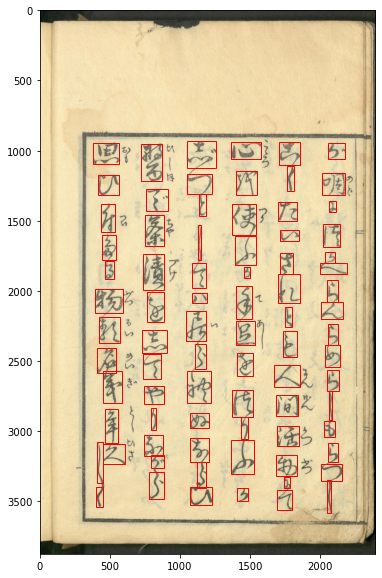

<Figure size 3600x3600 with 0 Axes>

In [7]:
img_num=1

rcParams['figure.figsize']=[10,10]
image_write(img_num,train_labels)

In [8]:
train_l,test_l=train_test_split(train_list,shuffle=True,test_size=0.3)

In [9]:
category_n=1
category=0
output_layer_n=category_n+4
input_h=input_w=512
output_h=output_w=128
filename=train_l
batch_size=64 
def c_model(filename,batch_size=32):
  x=[]
  y=[]
  count=0

  for i in range(len(filename)):
        with Image.open(filename[i][0]) as f:
            pic_h,pic_w=f.size
            pic_w=(pic_w*57)/100
            pic_h=(pic_h*15)/10
            f=np.asarray(f.convert('RGB'),dtype=np.uint8)
            #imagepath=f
            #imcv=cv2.imread(imagepath)
            f=cv2.resize(f,(input_h,input_w))
            x.append(f)
        output_layer=np.zeros((output_h,output_w,(output_layer_n+category_n)))
        for b in filename[i][1] :
                xc=b[1]
                yc=b[2]
                width=b[3]
                height=b[4]
                x_c, y_c, width, height = xc*output_h/(pic_w), yc*output_h/(pic_h), width*output_w/pic_w, height*output_h/pic_h
                if x_c//1 >= 128:
                    x_c=0
                if y_c//1 >= 128:
                    y_c=0
               
                
                heatmap=(((np.exp(-(((np.arange(output_w)-x_c)/(width/10))**2)/2)).reshape(1,-1))*(np.exp(-(((np.arange(output_h)-y_c)/(height/10))**2)/2)).reshape(-1,1))
               #print(heatmap)
                output_layer[:,:,category]=np.maximum(output_layer[:,:,category],heatmap[:,:])
                output_layer[int(y_c//1),int(x_c//1),category_n+category]=1
                output_layer[int(y_c//1),int(x_c//1),2*category_n]=y_c%1
                output_layer[int(y_c//1),int(x_c//1),2*category_n+1]=x_c%1
                output_layer[int(y_c//1),int(x_c//1),2*category_n+2]=height/output_h
                output_layer[int(y_c//1),int(x_c//1),2*category_n+3]=width/output_w
        y.append(output_layer)
        count+=1
        if count==batch_size:
            x=np.array(x,dtype='float32')
            y=np.array(y,dtype='float32')
            inputs=x/255
            targets=y
            x=[]
            y=[]
            count=0 
            yield inputs,targets

In [10]:
def offset_loss(y_true,y_pred):
     mask=K.sign(y_true[...,2*category_n+2])
     N=K.sum(mask)
     offsetloss=K.sum(K.abs(y_true[...,2*category_n]-y_pred[...,category_n]*mask)+K.abs(y_true[...,2*category_n+1]-y_pred[...,category_n+1]*mask))
     return (offsetloss)/(N+1e-5)

In [11]:
def size_loss(y_true,y_pred):
     mask=K.sign(y_true[...,2*category_n+2])
     N=K.sum(mask)
     sizeloss=K.sum(K.abs(y_true[...,2*category_n+2]-y_pred[...,category_n+2]*mask)+K.abs(y_true[...,2*category_n+3]-y_pred[...,category_n+3]*mask))
     return (2*sizeloss)/(N+1e-5)

In [12]:
def heatmap_loss(y_true,y_pred):
     mask=K.sign(y_true[...,2*category_n+2])
     N=K.sum(mask)
     alpha=2.
     beta=4.
     heatmap_true_rate = K.flatten(y_true[...,:category_n])
     heatmap_true = K.flatten(y_true[...,category_n:(2*category_n)])
     heatmap_pred = K.flatten(y_pred[...,:category_n])
     heatloss=-K.sum(heatmap_true*((1-heatmap_pred)**alpha)*K.log(heatmap_pred+1e-6)+(1-heatmap_true)*((1-heatmap_true_rate)**beta)*(heatmap_pred**alpha)*K.log(1-heatmap_pred+1e-6))
     return heatloss/(N+0.0000001)

In [13]:
def all_loss(y_true,y_pred):
    mask=K.sign(y_true[...,2*category_n+2])
    N=K.sum(mask)
    alpha=2.
    beta=4.
    heatmap_true_rate = K.flatten(y_true[...,:category_n])
    heatmap_true = K.flatten(y_true[...,category_n:(2*category_n)])
    heatmap_pred = K.flatten(y_pred[...,:category_n])
    heatloss=-K.sum(heatmap_true*((1-heatmap_pred)**alpha)*K.log(heatmap_pred+1e-6)+(1-heatmap_true)*((1-heatmap_true_rate)**beta)*(heatmap_pred**alpha)*K.log(1-heatmap_pred+1e-6))
    sizeloss=K.sum(K.abs(y_true[...,2*category_n+2]-y_pred[...,category_n+2]*mask)+K.abs(y_true[...,2*category_n+3]-y_pred[...,category_n+3]*mask))
    offsetloss=K.sum(K.abs(y_true[...,2*category_n]-y_pred[...,category_n]*mask)+K.abs(y_true[...,2*category_n+1]-y_pred[...,category_n+1]*mask))
    all_loss=(heatloss+1.0*offsetloss+5.0*sizeloss)/N
    return all_loss

In [14]:
def conv(x,y,k,s):
      x=Conv2D(y,kernel_size=k,strides=s,padding='same')(x)
      x=BatchNormalization()(x)
      x=LeakyReLU(alpha=0.1)(x)
      return x
def conv1(a,b,c,d):
      b=Conv2DTranspose(c,kernel_size=2,strides=2,padding='valid',use_bias=False)(b)
      b=BatchNormalization()(b)
      b=LeakyReLU(alpha=0.1)(b)
      x=Concatenate()([a,b])
      x=Conv2D(d,kernel_size=1,strides=1,padding='same')(x)
      x=BatchNormalization()(x)
      x=LeakyReLU(alpha=0.1)(x)
      return x
def adding(a,b):
     x=conv(a,b,3,1)
     x=conv(x,b,3,1)
     x=Add()([x,a])
     return x

In [20]:
def create_model(input_shape):
     input_layer=Input(input_shape)
     input_layer_1=AveragePooling2D(2)(input_layer)
     input_layer_2=AveragePooling2D(2)(input_layer_1)
     x_0=conv(input_layer,16,3,2)
     concat1=Concatenate()([x_0,input_layer_1])
     x_1=conv(concat1,32,3,2)
     concat2=Concatenate()([x_1,input_layer_2])
     x_2=conv(concat2,64,3,2)
     x=conv(x_2,64,3,1)
     x=adding(x,64)
     x=adding(x,64)
     x_3=conv(x,128,3,2)
     x=conv(x_3,128,3,1)
     x=adding(x,128)
     x=adding(x,128)
     x=adding(x,128)
     x_4=conv(x,256,3,2)
     x=conv(x_4,256,3,1)
     x=adding(x,256)
     x=adding(x,256)
     x=adding(x,256)
     x=adding(x,256)
     x=adding(x,256)
     x_5=conv(x,512,3,2)
     x=conv(x_5,512,3,1)
     x=adding(x,512)
     x=adding(x,512)
     x=adding(x,512)
     x_1= conv(x_1, output_layer_n, 1, 1)
     x_1 = conv1(x_1, x_2, output_layer_n, output_layer_n)
     x_2= conv(x_2, output_layer_n, 1, 1)
     x_2 = conv1(x_2, x_3, output_layer_n, output_layer_n)
     x_1 = conv1(x_1, x_2, output_layer_n, output_layer_n)
     x_3= conv(x_3, output_layer_n, 1, 1)
     x_3 = conv1(x_3, x_4, output_layer_n, output_layer_n) 
     x_2 = conv1(x_2, x_3, output_layer_n, output_layer_n)
     x_1 = conv1(x_1, x_2, output_layer_n, output_layer_n)
     x_4= conv(x_4, output_layer_n, 1, 1)
     x=conv(x, output_layer_n, 1, 1)
     x= UpSampling2D(size=(2, 2))(x)
     x = Concatenate()([x, x_4])
     x=conv(x, output_layer_n, 3, 1)
     x= UpSampling2D(size=(2, 2))(x)
     x = Concatenate()([x, x_3])
     x=conv(x, output_layer_n, 3, 1)
     x= UpSampling2D(size=(2, 2))(x)
     x = Concatenate()([x, x_2])
     x=conv(x, output_layer_n, 3, 1)
     x= UpSampling2D(size=(2, 2))(x) 
     x = Concatenate()([x, x_1])
     x=Conv2D(output_layer_n, kernel_size=3, strides=1, padding="same")(x)
     out = Activation("sigmoid")(x)
     model=Model(input_layer,out)
     return model

In [15]:
def lrs(epoch):
    lr = 0.001
    if epoch >= 20: lr = 0.0002
    return lr
learning_rate=0.001

In [21]:
model=create_model(input_shape=(512,512,3))
print(model.summary())
lr_schedule = LearningRateScheduler(lrs)

            
__________________________________________________________________________________________________
batch_normalization_31 (BatchNo (None, 8, 8, 512)    2048        conv2d_31[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_31 (LeakyReLU)      (None, 8, 8, 512)    0           batch_normalization_31[0][0]     
__________________________________________________________________________________________________
add_10 (Add)                    (None, 8, 8, 512)    0           leaky_re_lu_31[0][0]             
                                                                 leaky_re_lu_29[0][0]             
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 8, 8, 512)    2359808     add_10[0][0]                     
________________________________________________________________________________________________

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta=0, patience = 60, verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 4, verbose = 1)
#model.load_weights('final_weights_new_epoch_2.h5')
model.compile(loss=all_loss, optimizer=Adam(lr=learning_rate), metrics=[heatmap_loss,size_loss,offset_loss])
batch_size=32
n_epoch=2
hist = model.fit(c_model(train_l),steps_per_epoch = len(train_l)//batch_size,epochs=n_epoch,validation_data=(c_model(test_l)),validation_steps = len(test_l)// batch_size,callbacks=[early_stopping,reduce_lr],shuffle=True,verbose=1)
model.save_weights('final_weights_new_epoch_2.h5')

In [22]:
m2=create_model(input_shape=(128,128,3))

In [23]:
m2.load_weights('C:/Users/ravin/Documents/final_weights_step21.h5')

W0723 15:00:27.988355 16924 functional.py:584] Model was constructed with shape (None, 128, 128, 3) for input Tensor("input_2:0", shape=(None, 128, 128, 3), dtype=float32), but it was called on an input with incompatible shape (None, 512, 512, 3).


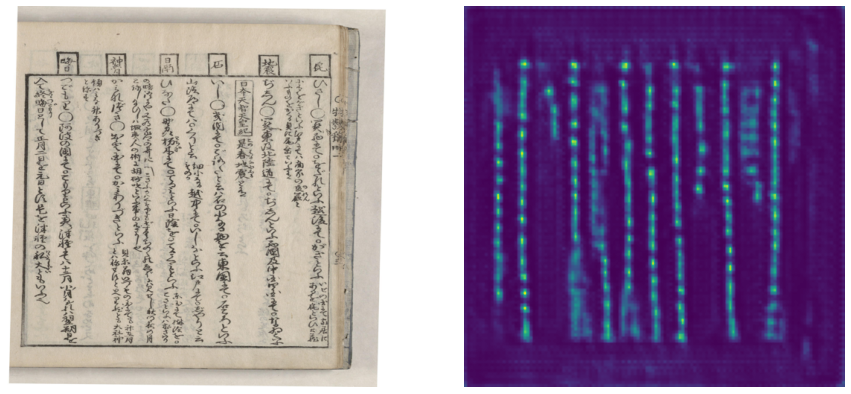

In [26]:
pred_in_h=512
pred_in_w=512
pred_out_h=128
pred_out_w=128
for i in np.arange(0,1):
  img = np.asarray(Image.open(test_l[i][0]).resize((pred_in_w,pred_in_h)).convert('RGB'))
  predict=m2.predict((img.reshape(1,pred_in_h,pred_in_w,3))/255).reshape(pred_out_h,pred_out_w,(category_n+4))
  heatmap=predict[:,:,0]

  fig, axes = plt.subplots(1, 2,figsize=(15,15))
  axes[0].set_axis_off()
  axes[0].imshow(img)
  axes[1].set_axis_off()
  axes[1].imshow(heatmap)
  plt.show()

score:0.249


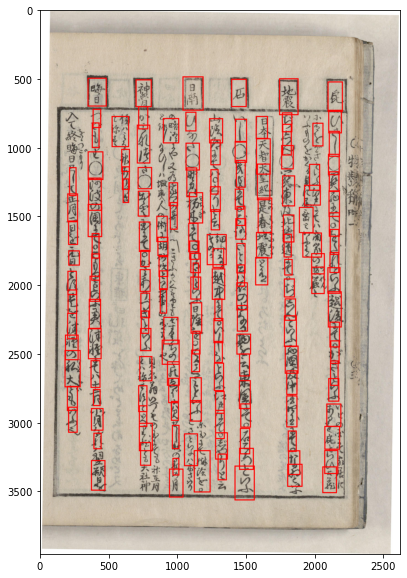

score:0.445


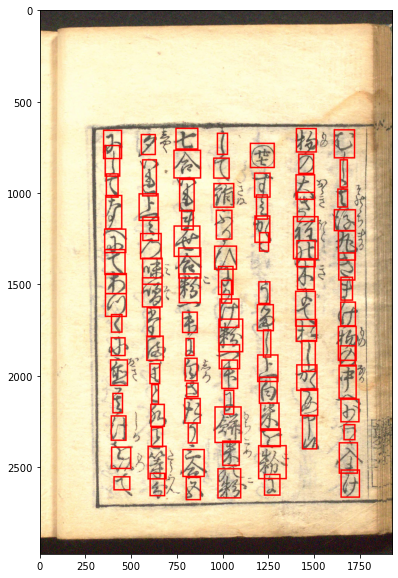

score:0.33


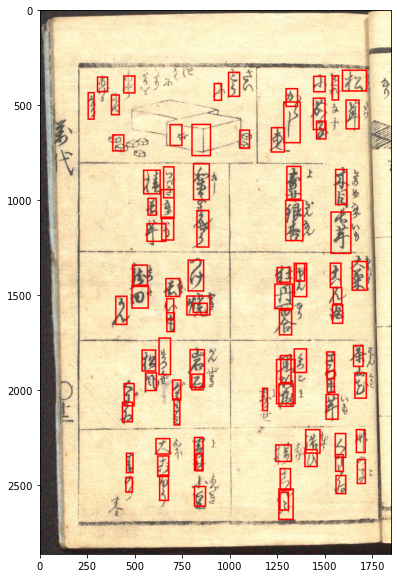

score:0.417


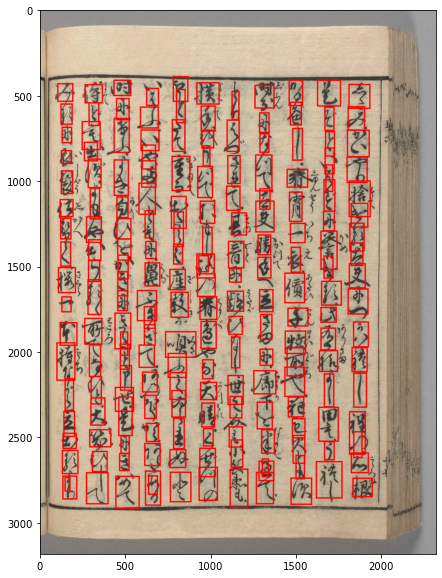

score:0.415


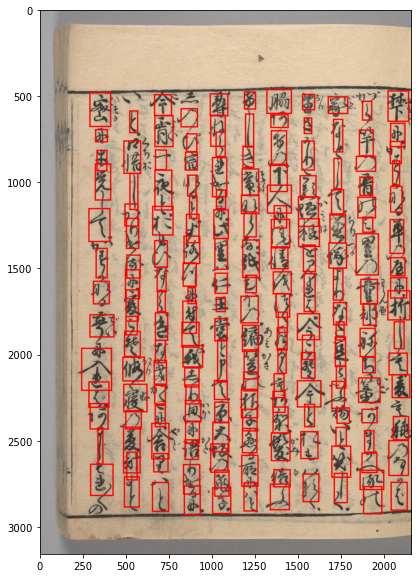

In [51]:
from PIL import Image, ImageDraw
def NMS_all(predicts,category_n,score_thresh,iou_thresh):
  y_c=predicts[...,category_n]+np.arange(pred_out_h).reshape(-1,1)
  x_c=predicts[...,category_n+1]+np.arange(pred_out_w).reshape(1,-1)
  height=predicts[...,category_n+2]*pred_out_h
  width=predicts[...,category_n+3]*pred_out_w
  count=0
  for category in range(category_n):
    predict=predicts[...,category]
    mask=(predict>score_thresh)
    if mask.all==False:
      continue
    box_and_score=NMS(predict[mask],y_c[mask],x_c[mask],height[mask],width[mask],iou_thresh)
    box_and_score=np.insert(box_and_score,0,category,axis=1)
    if count==0:
      box_and_score_all=box_and_score
    else:
      box_and_score_all=np.concatenate((box_and_score_all,box_and_score),axis=0)
    count+=1
  score_sort=np.argsort(box_and_score_all[:,1])[::-1]
  box_and_score_all=box_and_score_all[score_sort]
  _,unique_idx=np.unique(box_and_score_all[:,2],return_index=True)
  return box_and_score_all[sorted(unique_idx)]
def NMS(score,y_c,x_c,height,width,iou_thresh,merge_mode=False):
  if merge_mode:
    score=score
    top=y_c
    left=x_c
    bottom=height
    right=width
  else:
    score=score.reshape(-1)
    y_c=y_c.reshape(-1)
    x_c=x_c.reshape(-1)
    height=height.reshape(-1)
    width=width.reshape(-1)
    size=height*width
    top=y_c-height/2
    left=x_c-width/2
    bottom=y_c+height/2
    right=x_c+width/2
    inside_pic=(top>0)*(left>0)*(bottom<pred_out_h)*(right<pred_out_w)
    outside_pic=len(inside_pic)-np.sum(inside_pic)
    normal_size=(size<(np.mean(size)*10))*(size>(np.mean(size)/10))
    score=score[inside_pic*normal_size]
    top=top[inside_pic*normal_size]
    left=left[inside_pic*normal_size]
    bottom=bottom[inside_pic*normal_size]
    right=right[inside_pic*normal_size]
  score_sort=np.argsort(score)[::-1]
  score=score[score_sort]  
  top=top[score_sort]
  left=left[score_sort]
  bottom=bottom[score_sort]
  right=right[score_sort]
  area=((bottom-top)*(right-left))
  boxes=np.concatenate((score.reshape(-1,1),top.reshape(-1,1),left.reshape(-1,1),bottom.reshape(-1,1),right.reshape(-1,1)),axis=1)
  box_idx=np.arange(len(top))
  alive_box=[]
  while len(box_idx)>0:
    alive_box.append(box_idx[0])
    y1=np.maximum(top[0],top)
    x1=np.maximum(left[0],left)
    y2=np.minimum(bottom[0],bottom)
    x2=np.minimum(right[0],right)
    cross_h=np.maximum(0,y2-y1)
    cross_w=np.maximum(0,x2-x1)
    still_alive=(((cross_h*cross_w)/area[0])<iou_thresh)
    if np.sum(still_alive)==len(box_idx):
      print("error")
      print(np.max((cross_h*cross_w)),area[0])
    top=top[still_alive]
    left=left[still_alive]
    bottom=bottom[still_alive]
    right=right[still_alive]
    area=area[still_alive]
    box_idx=box_idx[still_alive]
  return boxes[alive_box]
def draw_rectangle(box_and_score,img,color):
  number_of_rect=np.minimum(500,len(box_and_score))
  for i in reversed(list(range(number_of_rect))):
    top, left, bottom, right = box_and_score[i,:]
    top = np.floor(top + 0.5).astype('int32')
    left = np.floor(left + 0.5).astype('int32')
    bottom = np.floor(bottom + 0.5).astype('int32')
    right = np.floor(right + 0.5).astype('int32')
    draw = ImageDraw.Draw(img)
    thickness=4
    if color=="red":
      rect_color=(255, 0, 0)
    elif color=="blue":
      rect_color=(0, 0, 255)
    else:
      rect_color=(0, 0, 0)
    if i==0:
      thickness=4
    for j in range(2*thickness):
      if(color=="blue"):
        draw.rectangle([left+40+j, top+40+j, right+40-j, bottom+40-j],
                    outline=rect_color)
      else:
        draw.rectangle([left+j, top+j, right-j, bottom-j],
                    outline=rect_color)
  del draw
  return img
def check_iou_score(true_boxes,detected_boxes,iou_thresh):
  iou_all=[]
  for detected_box in detected_boxes:
    y1=np.maximum(detected_box[0],true_boxes[:,0])
    x1=np.maximum(detected_box[1],true_boxes[:,1])
    y2=np.minimum(detected_box[2],true_boxes[:,2])
    x2=np.minimum(detected_box[3],true_boxes[:,3])
    cross_section=np.maximum(0,y2-y1)*np.maximum(0,x2-x1)
    all_area=(detected_box[2]-detected_box[0])*(detected_box[3]-detected_box[1])+(true_boxes[:,2]-true_boxes[:,0])*(true_boxes[:,3]-true_boxes[:,1])
    iou=np.max(cross_section/(all_area-cross_section))
    iou_all.append(iou)
  score=5*np.sum(iou_all)/(len(detected_boxes)+len(true_boxes))
  print("score:{}".format(np.round(score,3)))
  return score
for i in np.arange(0,5):
  img=Image.open(test_l[i][0]).convert("RGB")
  width,height=img.size
  predict=m2.predict((np.asarray(img.resize((pred_in_w,pred_in_h))).reshape(1,pred_in_h,pred_in_w,3))/255).reshape(pred_out_h,pred_out_w,(category_n+4))
  box_and_score=NMS_all(predict,category_n,score_thresh=0.3,iou_thresh=0.4)
  if len(box_and_score)==0:
    continue
  true_boxes=test_l[i][1][:,1:]
  top=true_boxes[:,1:2]-true_boxes[:,3:4]/2
  left=true_boxes[:,0:1]-true_boxes[:,2:3]/2
  bottom=top+true_boxes[:,3:4]
  right=left+true_boxes[:,2:3]
  true_boxes=np.concatenate((top,left,bottom,right),axis=1)
  heatmap=predict[:,:,0]
  print_w, print_h = img.size
  box_and_score=box_and_score*[1,1,print_h/pred_out_h,print_w/pred_out_w,print_h/pred_out_h,print_w/pred_out_w]
  check_iou_score(true_boxes,box_and_score[:,2:],iou_thresh=0.5)
  img=draw_rectangle(box_and_score[:,2:],img,"red")
  #img=draw_rectangle(true_boxes,img,"blue")
  #fig, axes = plt.subplots(1, 2,figsize=(15,15))
  plt.imshow(img)
  #axes[1].imshow(heatmap)
  plt.show()